# Application to Insurance Pricing

Business case problems: <br>
Predict whether the policyholder makes a claim or not by using two variables, such as the age of the policyholder and the power of the car.

The dataset we use:
- Unit of analysis: Each policyholder
- Data range: Unknown

## Import libraries and dataset

In [1]:
import time
import os
import pydotplus

ModuleNotFoundError: No module named 'pydotplus'

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from IPython.display import Image

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold
from sklearn.inspection import plot_partial_dependence, partial_dependence
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score
import xgboost as xgb
from six import StringIO

In [2]:
import pandas as pd
df = pd.read_csv('../working_data/sim_db.csv')

## Check the data

In [3]:
# Check the shape of the data
df.shape

(20000, 3)

In [14]:
# Check the basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
age      20000 non-null int64
power    20000 non-null int64
N        20000 non-null int64
dtypes: int64(3)
memory usage: 468.8 KB


In [9]:
# Show the 5 above rows
df.head(5)

,age,power,N
0,79,38,0
1,53,29,0
2,41,32,0
3,20,24,0
4,54,12,0


In [15]:
# Show the 5 below rows
df.tail(5)

,age,power,N
19995,41,65,0
19996,25,48,2
19997,55,23,1
19998,60,60,0
19999,34,14,0


Here, the definitions of variables are
- age: the age of the policyholder
- power: the power of the car
- N: the number of claims reported by the policyholder

In [16]:
# Basic statistics
df.describe()

,age,power,N
count,20000.000000,20000.000000,20000.000000
mean,49.856150,39.879500,0.116100
std,17.619761,17.578198,0.368141
min,20.000000,10.000000,0.000000
25%,34.000000,25.000000,0.000000
50%,50.000000,40.000000,0.000000
75%,65.000000,55.000000,0.000000
max,80.000000,70.000000,4.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000203A2F69278>,
      dtype=object)

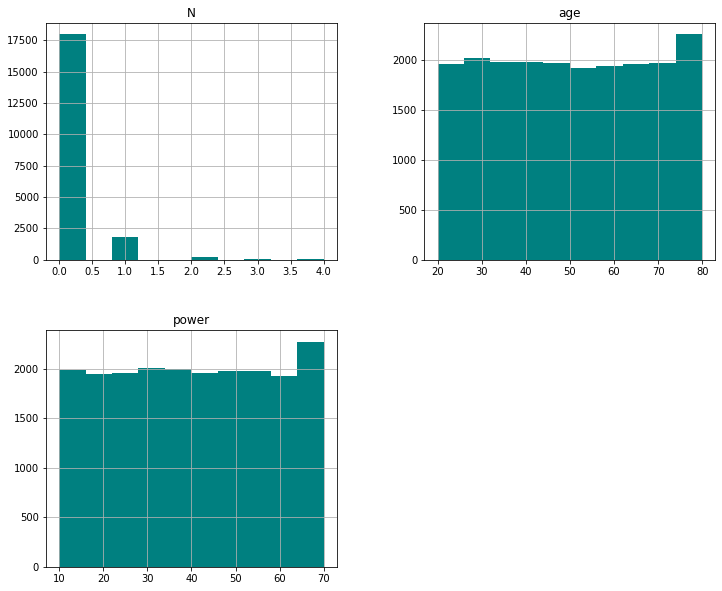

In [17]:
# SHow the distributions of variables
df.hist(bins=10, figsize=(12,10), color = 'teal')

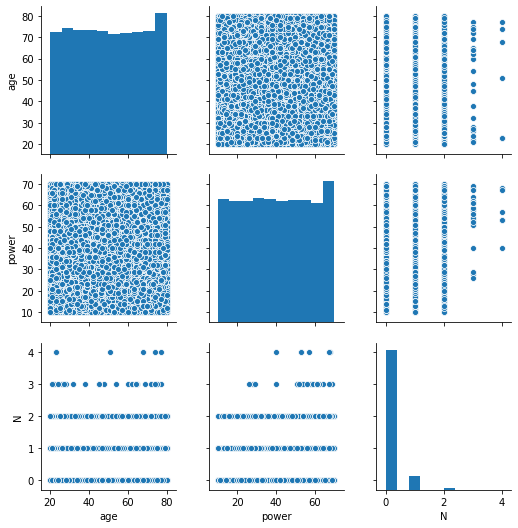

In [21]:
# correlation plots
sns.pairplot(df)

In [18]:
# How many policyholders made claims once or more
len(df[(df.N>0)]) / len(df)

0.10175

It seems about 10% of policyholders made claims.

In [19]:
# Check the number of missing values
df.isnull().sum()

age      0
power    0
N        0
dtype: int64

## Preprocess the data

In [25]:
# Create new variables: making claims or not
df["one"] = 1
df["claim_binary"] = df["one"].where(df["N"]>0, 0)
df = df.drop("one", axis=1)

## Divide the data

In [44]:
# Assign the variables to X and y
y = df["claim_binary"]
X = df.drop(["N", "claim_binary"], axis=1)

In [45]:
# divide the dataset
X_train,X_test,y_train, y_test = train_test_split(X, y, stratify = y, random_state=1, test_size=0.2)

In [46]:
len(X_train), len(X_test)

(16000, 4000)

In [47]:
len(y_train),len(y_test)

(16000, 4000)

## Modeling

### Fitting

In [49]:
# Random Forest Classification
rf_cls = RandomForestClassifier(random_state=1)
rf_cls.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [53]:
# XGBoost Classification
xgb_cls = RandomForestClassifier(random_state=1)
xgb_cls.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Prediction

In [51]:
# Random Forest Classification
rf_pred = rf_cls.predict(X_test)
rf_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [54]:
# XGBoost Classification
xgb_pred = xgb_cls.predict(X_test)
xgb_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

### Check the accuracies 

#### Reports

In [55]:
# Random Forest Classification
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3593
           1       0.15      0.04      0.06       407

    accuracy                           0.88      4000
   macro avg       0.52      0.51      0.50      4000
weighted avg       0.82      0.88      0.85      4000



In [56]:
# XGBoost Classification
xgb_report = classification_report(y_test, xgb_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      3593
           1       0.15      0.04      0.06       407

    accuracy                           0.88      4000
   macro avg       0.52      0.51      0.50      4000
weighted avg       0.82      0.88      0.85      4000



#### Heatmaps

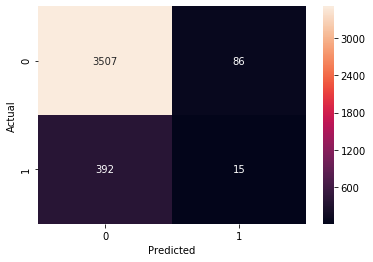

In [57]:
rf_cm = confusion_matrix(y_test, rf_pred)
df_rf_cm = pd.DataFrame(rf_cm, columns=np.unique(y_test), index = np.unique(y_test))
df_rf_cm.index.name = 'Actual'
df_rf_cm.columns.name = 'Predicted'
sns.heatmap(df_rf_cm, annot=True, fmt='d')

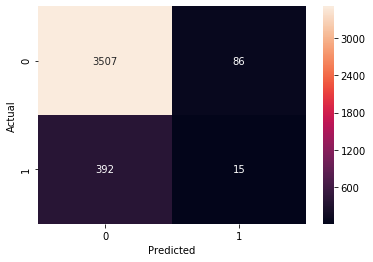

In [58]:
xgb_cm = confusion_matrix(y_test, xgb_pred)
df_xgb_cm = pd.DataFrame(xgb_cm, columns=np.unique(y_test), index = np.unique(y_test))
df_xgb_cm.index.name = 'Actual'
df_xgb_cm.columns.name = 'Predicted'
sns.heatmap(df_xgb_cm, annot=True, fmt='d')

As we see, because the response variable is imbalanced, the model underestimate the probablity that the policyholder makes a claim.  <br>

## Divide the data with SMOTE techniques

In [66]:
from imblearn.over_sampling import SMOTE
X_balance,y_balance = SMOTE().fit_sample(X,y)
X_balance = pd.DataFrame(X_balance,columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_balance, y_balance, 
                                                    stratify=y_balance, 
                                                    random_state = 1,
                                                    test_size=0.2,)

## Modeling

### Fitting

In [67]:
# Random Forest Classification
rf_cls = RandomForestClassifier(random_state=1)
rf_cls.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [68]:
# XGBoost Classification
xgb_cls = RandomForestClassifier(random_state=1)
xgb_cls.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

### Prediction

In [69]:
# Random Forest Classification
rf_pred = rf_cls.predict(X_test)
rf_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

In [70]:
# XGBoost Classification
xgb_pred = xgb_cls.predict(X_test)
xgb_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

### Check the accuracies 

#### Reports

In [71]:
# Random Forest Classification
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      3593
           1       0.71      0.80      0.75      3593

    accuracy                           0.74      7186
   macro avg       0.74      0.74      0.74      7186
weighted avg       0.74      0.74      0.74      7186



In [72]:
# XGBoost Classification
xgb_report = classification_report(y_test, xgb_pred)
print(xgb_report)

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      3593
           1       0.71      0.80      0.75      3593

    accuracy                           0.74      7186
   macro avg       0.74      0.74      0.74      7186
weighted avg       0.74      0.74      0.74      7186



#### Heatmaps

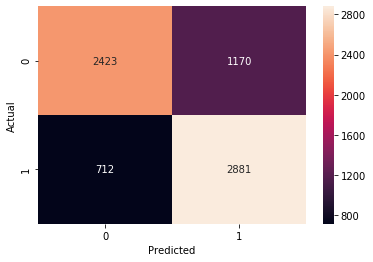

In [73]:
rf_cm = confusion_matrix(y_test, rf_pred)
df_rf_cm = pd.DataFrame(rf_cm, columns=np.unique(y_test), index = np.unique(y_test))
df_rf_cm.index.name = 'Actual'
df_rf_cm.columns.name = 'Predicted'
sns.heatmap(df_rf_cm, annot=True, fmt='d')

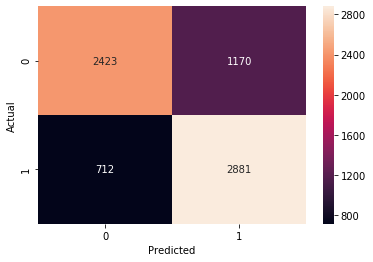

In [74]:
xgb_cm = confusion_matrix(y_test, xgb_pred)
df_xgb_cm = pd.DataFrame(xgb_cm, columns=np.unique(y_test), index = np.unique(y_test))
df_xgb_cm.index.name = 'Actual'
df_xgb_cm.columns.name = 'Predicted'
sns.heatmap(df_xgb_cm, annot=True, fmt='d')

Here, the prediction power becomes increased by using SMOTE for the imbalanced data! <br>
By these prediction models, we can tell the policyholders who have the higher possibility of making a claim from those who do not have such a possibility.

## Interpretation

### Feature Importances

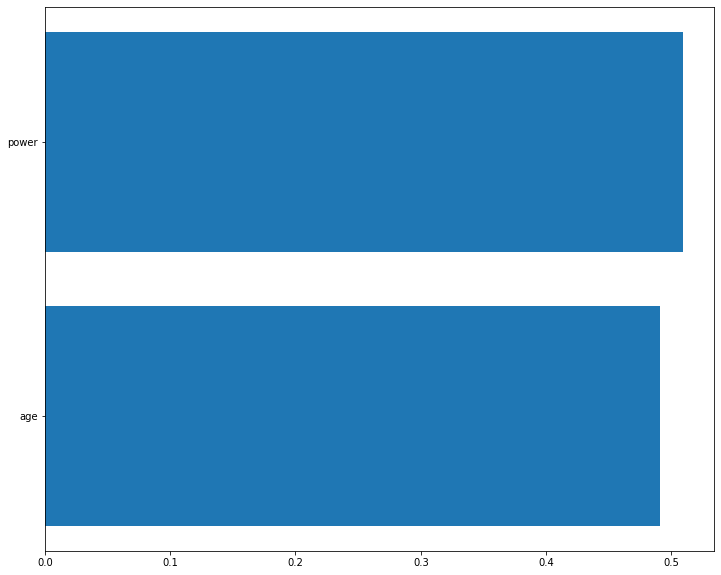

In [75]:
features = X_train.columns
importances = rf_cls.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,10))
plt.barh(range(len(indices)), importances[indices],  align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

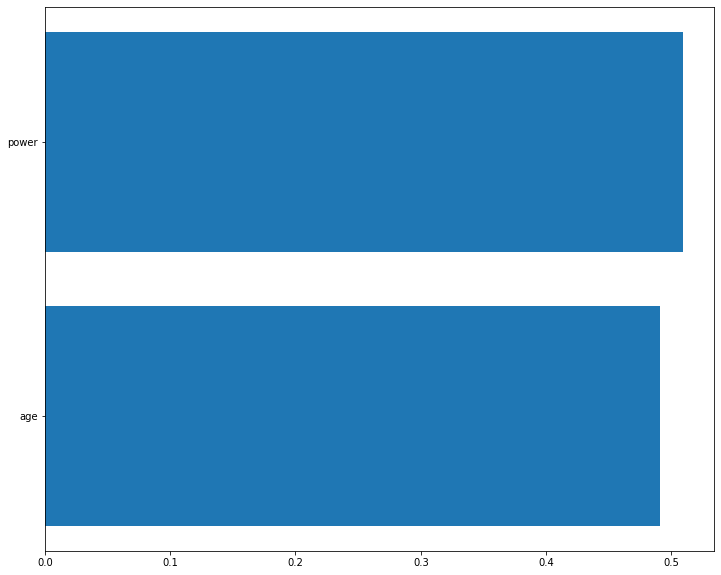

In [76]:
features = X_train.columns
importances = xgb_cls.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,10))
plt.barh(range(len(indices)), importances[indices],  align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()

Seemingly, power is a more important factor than age.

### Prediction probability


In [80]:
# Random Forest model
mat_rf_prob = rf_cls.predict_proba(X_test)

# XGB model
mat_xgb_prob = xgb_cls.predict_proba(X_test)

In [81]:
mat_rf_prob

array([[0.98905556, 0.01094444],
       [0.3602563 , 0.6397437 ],
       [0.82525921, 0.17474079],
       ...,
       [0.4480575 , 0.5519425 ],
       [0.38542832, 0.61457168],
       [0.04174207, 0.95825793]])

In [82]:
mat_xgb_prob

array([[0.98905556, 0.01094444],
       [0.3602563 , 0.6397437 ],
       [0.82525921, 0.17474079],
       ...,
       [0.4480575 , 0.5519425 ],
       [0.38542832, 0.61457168],
       [0.04174207, 0.95825793]])

It seems weird that there is no difference btw rf model and xgb model in the results, but anyway we can judge the policyholders based on the probabilities.